In [1]:
import xml.etree.ElementTree as ET
import json
from collections import OrderedDict
import numpy as np
import random
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Change the file path to your current path if you want to reuse the code. 

## Parse the xml files into a total dictionary

Code below is a modified version of xml parser: 
Achakulvisut et al., (2020). Pubmed Parser: A Python Parser for PubMed Open-Access XML Subset and MEDLINE XML Dataset XML Dataset. Journal of Open Source Software, 5(46), 1979, https://doi.org/10.21105/joss.01979

In [25]:

# find all keywords from the kwd xml tag
def getKeywords(path):
    temp = ET.parse(path).getroot()
    try:
        kwds = []
        for group in temp.findall('.//kwd-group'):
            for kwd in group.findall('kwd'):
                s = ''
                for t in kwd.itertext():
                    text = t.replace("\n", " ").replace("\t", " ").strip()
                    s += text
                kwds.append(s)
        return kwds
    except BaseException:
        return []

# find abstract from the abstract xml tag
def getAbstract(path):
    temp = ET.parse(path).getroot()
    try:
        abstracts = []
        abstract_tree = temp.findall(".//abstract")
        for a in abstract_tree:
            for p in a.findall('.//p'):
                for t in p.itertext():
                    text = t.replace("\n", " ").replace("\t", " ").strip()
                    abstracts.append(text)
        abstract = " ".join(abstracts)
        return abstract
    except BaseException:
        abstract = ""
        return abstract
import os

# find title from the title xml tag
def getTitle(path):
    tree = ET.parse(path).getroot()
    tree_title = tree.find(".//title-group/article-title")
    if tree_title is not None:
        title = [t for t in tree_title.itertext()]
        title = [t.replace("\n", " ").replace("\t", " ") for t in title]
        full_title = " ".join(title)
    else:
        full_title = ""
    return full_title.strip()

 # helper method that gets the full path of xml file
def list_xml_path(path_dir):
    fullpath = [
        os.path.join(dp, f)
        for dp, dn, fn in os.walk(os.path.expanduser(path_dir))
        for f in fn
    ]
   
    path_list = [
        folder
        for folder in fullpath
        if os.path.splitext(folder)[-1] in (".nxml", ".xml")
    ]
    return path_list


if __name__ == "__main__":
    # change the file path
    filename = '/home/ubuntu/pubmed/dataset/total.json'
    f = open(filename,)
    # if there is no data, then begin parsing
    try:
        final = json.load(f)
    except:
        final = OrderedDict()
    
    f = open(filename, 'w')
    
    path_xml = list_xml_path(
        '/home/ubuntu/pubmed/data/O')  # list all xml paths under directory

    for path in path_xml:
        # get keywords, abstract and title for each file in the path
        keywords = getKeywords(path)
        abstract = getAbstract(path)
        title = getTitle(path)
        # ignore the file that failed to be parsed
        if title == "" or abstract == "" or keywords == []:
            continue
        # seperate words that is in the abstract and that is not in the abstract
        contain = []
        not_contain = []
        for word in keywords:
            if word.lower() in abstract.lower():
                contain.append(word)
            else:
                not_contain.append(word)

        result = {"title":title, "abstract":abstract,"keywords_in":contain, "keywords_not_in":not_contain}
        # index as the PMCxxxxxx PMC id
        index = re.split("\.",re.split("/",path)[-1])[0]
        final[index] = result

    json.dump(final, f, indent = 4)
    f.close()



### Seperate the total dictionary into train-test-validation split.

In [36]:
f = open('/home/ubuntu/pubmed/dataset/total.json')
total = json.load(f)
f.close()


In [32]:
total_len = len(total)
test_len = int(total_len * 0.2)
validate_len = int(test_len)
train_len = int(total_len - test_len * 2)

print(train_len)
print(test_len)
print(validate_len)

505959
168653
168653


In [ ]:
ftrain = open('/home/ubuntu/pubmed/dataset/train.json', 'w')
ftest = open('/home/ubuntu/pubmed/dataset/test.json', 'w')
fvalidate = open('/home/ubuntu/pubmed/dataset/validate.json', 'w')

test = {}
train = {}
validate = {}
testc = 0
trainc = 0
validatec = 0

# iterate the whole dictionary to put total dict elements into 3 buckets
for key, val in total.items():
    #if test dict is not full
    if testc != test_len:
        test[key] = val
        testc += 1
    elif trainc != train_len:
        train[key] = val
        trainc += 1
    else:
        validate[key] = val

json.dump(test, ftest, indent = 4)
json.dump(train, ftrain, indent = 4)
json.dump(validate, fvalidate, indent = 4)

ftrain.close()
ftest.close()
fvalidate.close()


## Create a small dataset for only 5-25 extractive keywords.

In [85]:
#create small dataset with only 5-25 extractive keywords
f = open('/home/ubuntu/pubmed/dataset/total.json')
temp_total = json.load(f)
f.close()


In [86]:
#filter dataset
total = {}
for key, val in temp_total.items():
    length = len(val["keywords_in"])
    if length < 26 and length >= 5:
        total[key] = val
        
total_len = len(total)
test_len = int(total_len * 0.2)
validate_len = int(test_len)
train_len = int(total_len - test_len * 2)

print(train_len)
print(test_len)
print(validate_len)

82011
27336
27336


In [29]:
ftrain = open('/home/ubuntu/pubmed/dataset/small_train.json', 'w')
ftest = open('/home/ubuntu/pubmed/dataset/small_test.json', 'w')
fvalidate = open('/home/ubuntu/pubmed/dataset/small_validate.json', 'w')

test = {}
train = {}
validate = {}
testc = 0
trainc = 0
validatec = 0

# iterate the whole dictionary to put total dict elements into 3 buckets
for key, val in total.items():
    #if test dict is not full
    if testc != test_len:
        test[key] = val
        testc += 1
    elif trainc != train_len:
        train[key] = val
        trainc += 1
    else:
        validate[key] = val

json.dump(test, ftest, indent = 4)
json.dump(train, ftrain, indent = 4)
json.dump(validate, fvalidate, indent = 4)

ftrain.close()
ftest.close()
fvalidate.close()


## Plot the distribution of keywords

plot for total keywords

In [82]:
f = open('/home/ubuntu/pubmed/dataset/total.json')
temp_total = json.load(f)
f.close()

In [83]:
inhist = []
outhist = []
for count, value in temp_total.items():
    t = len(value["keywords_in"])
    if t < 26:
        inhist.append(t)
    t = len(value["keywords_not_in"])
    if t < 26:
        outhist.append(t)
histdata = {"keywords_in":inhist, "keywords_not_in":outhist}

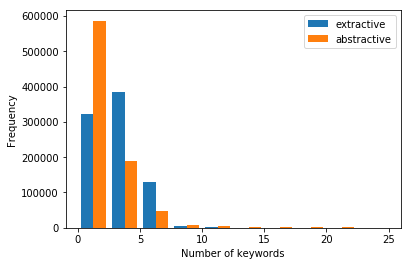

In [59]:
plt.hist([inhist, outhist], label=['extractive', 'abstractive'])
plt.legend(loc='upper right')
plt.xlabel("Number of keywords")
plt.ylabel("Frequency")
plt.show()

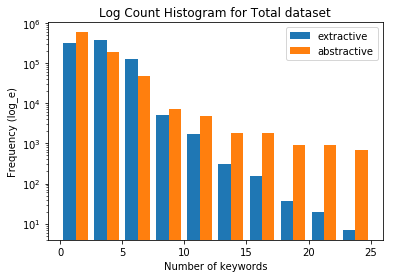

In [84]:
plt.hist([inhist, outhist], label=['extractive', 'abstractive'])
plt.legend(loc='upper right')
plt.xlabel("Number of keywords")
plt.yscale('log')
plt.title("Log Count Histogram for Total dataset")
plt.ylabel("Frequency (log_e)")
plt.show()

plot for small dataset keywords

In [62]:
inhist = []
for count, value in total.items():
    t = len(value["keywords_in"])
    inhist.append(t)


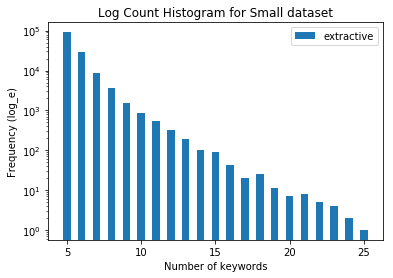

In [87]:
plt.hist([inhist], label=['extractive'],rwidth = 0.5, align = 'left', bins = list(range(5,27)))
plt.legend(loc='upper right')
plt.xlabel("Number of keywords")
plt.yscale('log')
plt.title('Log Count Histogram for Small dataset')
plt.ylabel("Frequency (log_e)")
plt.show()